In [1]:
import numpy as np
from numpy.linalg import norm as nln
import matplotlib.pyplot as plt

In [41]:
def euclidean_proj_simplex(v, s=1):
    assert s > 0, "Radius s must be strictly positive (%d <= 0)" % s
    n, = v.shape 
    if v.sum() == s and np.alltrue(v >= 0):
        # best projection: itself!
        return v
    u = np.sort(v)[::-1]
    cssv = np.cumsum(u)
    rho = np.nonzero(u * np.arange(1, n+1) > (cssv - s))[0][-1]
    theta = (cssv[rho] - s) / (rho + 1.0)
    w = (v - theta).clip(min=0)
    return w

def shrinkc2(v, s=1):
    assert s > 0, "Radius s must be strictly positive (%d <= 0)" % s
    n, = v.shape 
    u = np.abs(v)
    if u.sum() <= s:
        # L1-norm is <= s
        return v
    w = euclidean_proj_simplex(u, s=s)
    w *= np.sign(v)
    return w

def get_sparse_randn(n, s):
    beta = np.random.randn(n)
    beta[np.argsort(np.random.randn(n))[:n-s]]=0
    return beta

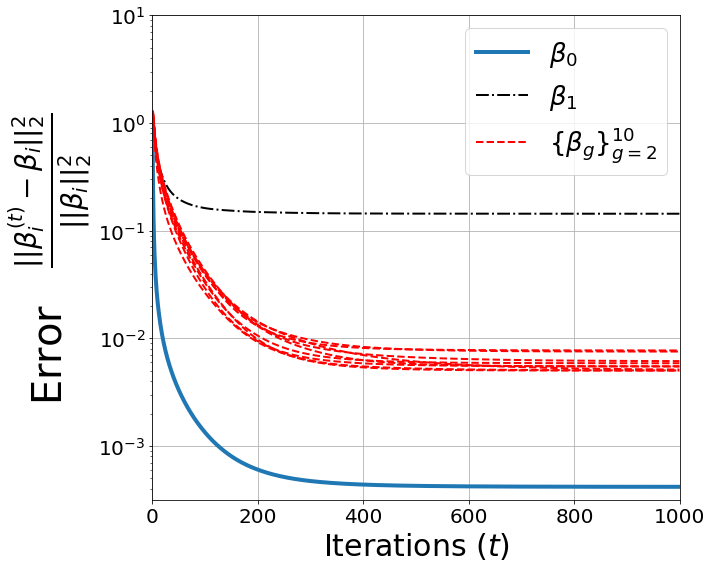

In [44]:
G=10
s=10
s0=100
p=100
ng=60
totit=10

grperr = np.zeros((G,itnum))
mainerr = np.zeros((itnum))

for _ in range(totit):
    betas=[]
    beta0=get_sparse_randn(p,s0)
    for i in range(G):
        betas.append(get_sparse_randn(p,s))
    As=[]
    ys=[]
    for i in range(G):
        As.append(np.random.randn(ng, p)/np.sqrt(ng))
        if i>=1:
            ys.append(As[i].dot(beta0+betas[i]))
        else:
            ys.append(As[i].dot(beta0+betas[i])+np.random.randn(ng)/np.sqrt(ng))

    # PGD algo
    itnum=1000
    mu_g=1./np.sqrt(G)#np.sqrt(G)
    mu_0=1./G#np.sqrt(G)
    betah0=np.zeros((p))
    betah = [np.zeros((p)) for i in range(G)]

    for it in range(itnum):
        mainerr[it]+=nln(beta0-betah0)**2/nln(beta0)**2
        for g in range(G):
            grperr[g,it]+=nln(betah[g]-betas[g])**2/nln(betas[g])**2
        for g in range(G):
            betah[g]+=mu_g*As[g].T.dot(ys[g]-As[g].dot(betah0+betah[g]))
            betah[g]=shrinkc2(betah[g],nln(betas[g],1))
        for g in range(G):
            betah0+=mu_0*As[g].T.dot(ys[g]-As[g].dot(betah0+betah[g]))

mainerr=mainerr/totit
grperr=grperr/totit
plt.figure(figsize=(10,8))
plt.semilogy(range(itnum),mainerr,linewidth=4)
plt.semilogy(range(itnum),grperr[0,:],'k-.',linewidth=2)
for g in range(1,G):
    plt.semilogy(range(itnum),grperr[g,:],'r--',linewidth=2)
plt.legend(['$\\beta_0$','$\\beta_1$', '$\{\\beta_g\}_{g=2}^{10}$'], fontsize=26)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.grid(True)
plt.xlim(0,1000)
plt.ylim(10**(-3.5),10)
plt.xlabel('Iterations ($t$)', fontsize=30)
plt.ylabel('Error   $\\frac{||\\beta_i^{(t)}-\\beta_i||_{2}^2}{||\\beta_i||_{2}^2}$', fontsize=40)
plt.tight_layout()
plt.savefig('betag_converge_noise_G10_p100.eps')